## 파이토치 기초(6) - FGSM (적대적 공격)

* day 1 - 텐서와 Autograd : https://dacon.io/codeshare/4478
* day 2 - 신경망모델 구현하기 : https://dacon.io/codeshare/4495
* day 3 - DNN : https://dacon.io/codeshare/4532
* day 4 - CNN : https://dacon.io/codeshare/4537
* day 5 - AutoEncoder 오토 인코더 : https://dacon.io/codeshare/4551

### 적대적 공격이란?

* 모든 머신러닝 분류기는 속임수에 의해 잘못된 예측을 할 수 있습니다.
* 입력 데이터가 신경망 모델을 타고 흐르면서 계속 변환이 일어나고, 각각의 변환이 입력의 특정 구조에 매우 예민하게 반응하기 때문에 예민하게 반응하는 부분을 공략하면 잘 학습된 딥러닝 모델도 실수를 일으키게 할 수 있습니다.
* 적대적 공격은 적절한 잡음(노이즈)를 생성해 사람의 눈에는 똑같이 보이지만, 머신러닝 모델을 헷갈리게 만드는 적대적 예제를 만드는 것이 핵심입니다.
* 인식 오류를 일으키지만 원본과 차이가 가장 적은 잡음을 찾아내야 하므로 오차를 극대화하는 잡음 최적화 문제로 해석할 수 있습니다.

적대적 예제에서 잡음의 생성 방법은 분류 기준이 무엇이냐에 따라 여러가지로 나뉩니다.
* 첫째, 기울기와 같은 모델 정보가 필요한지에 따라, 모델 정보를 토대로 잡음을 생성하는 화이트 박스(white box) 방법과 모델 정보 없이 생성하는 블랙박스(black box)로 나뉩니다.
* 둘째, 원하는 정답으로 유도할 수 있다면 표적(targeted),아니라면 비표적(non-targeted)으로 분류합니다.
* 셋째, 잡음을 생성하기 위해 반복된 학습(최적화)이 필요하면 반복(iterative), 아니면 원샷(one-shot)으로 나눌 수 있습니다.
* 넷째, 한 잡음이 특정 입력에만 적용되는지, 혹은 모든 이미지에 적용될 수 있는 범용적인 잡음인지로 나눌 수 있습니다.

가장 강력한 공격 방법은 모델 정보가 필요없고, 원하는 정답으로 유도할 수 있고, 복잡한 학습이 필요하지 않으며, 여러 모델에 동시에 적용할 수 있는 방법이겠지만, 각 특징에는 기회비용이 존재합니다. 여러 모델에 동시에 정답을 유도하게 하는 강력한 공격을 위해서는 모델에 대한 정보가 많아야 하고 복잡한 최적화 과정을 거쳐야 하기 때문에 쉽지 않습니다.

### FGSM (Fast Gradient Sign Method) 공격

* 정상 데이터에 잡음을 더해 머신러닝 모델을 헷갈리게 하는 데이터가 적대적 예제입니다. 
* FGSM은 반복된 학습없이 잡음을 생성하는 원샷공격으로, 입력 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성합니다.
* 잡음에 아주 작은 숫자를 곱해서 희석한 후 원본에 더하는 방식을 사용하며 최적화를 반복하여 더 정교한 잡음을 만들 수도 있습니다.

FGSM (Fast Gradient Sign Method)방법으로 적대적 예제를 생성해, 미리 학습된 딥러닝 모델을 공격해보겠습니다.

In [1]:
# 라이브러리 임포트
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

토치비전은 AlexNet, VGG, ResNet, SqueezeNet, DenseNet, Inception 등 여러가지 학습된 모델을 제공합니다. 대부분은 컬러 이미지를 다루는 컴퓨터 비전 분야의 대표적인 데이터셋인 이미지넷 데이터셋으로 학습된 모델입니다.

In [2]:
#학습된 모델 불러오기
model = models.resnet101(pretrained=True)
# 사용할 모델을 가져오는 models.모델명 함수를 호출할 때 인수로 (pretrained=True)를 명시하면 학습이 완료된 모델을 사용할 수 있습니다.
model.eval()
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\syi06/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

https://github.com/keon/3-min-pytorch/tree/master/08-%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84_%ED%95%B4%ED%82%B9%ED%95%98%EB%8A%94_%EC%A0%81%EB%8C%80%EC%A0%81_%EA%B3%B5%EA%B2%A9/imagenet_samples

* 링크의 폴더를 다운받아 사용합니다.

In [7]:
# json파일을 불러와 딕셔너리 형태로 만든 후 번호를 레이블 이름으로 변환해주는 idx2class 리스트를 만듭니다
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [8]:
# 공격하고자 하는 이미지를 불러옵니다.
# 이미지넷 데이터셋에 존재하는 펨브르크 웰시코기 클래스의 웰시코기 사진을 불러옵니다.
img = Image.open('imagenet_samples/corgie.jpg')

In [9]:
# 이미지를 파이토치 텐서로 변환하기
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])
# img_transforms를 통과하면 어떤 이미지라도 입력으로 사용할 수 있습니다.

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0) # unsqueeze(0)을 통해 3x224x224 이미지를 1x3x224x224로 배치하기 위해 1차원을 늘려줍니다.

print("이미지 텐서 모양:", img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


C:\Users\syi06\.conda\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


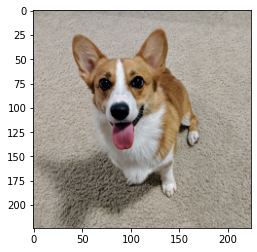

In [10]:
# 원본 이미지 텐서의 시각화를 위해 넘파이 행렬 변환
original_img_view = img_tensor.squeeze(0).detach()  
# squeeze()로 다시 차원을 줄입니다. [1, 3, 244, 244] -> [3, 244, 244]
# detach()로 원본 이미지 텐서와 연결을 끊습니다.
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()
# transpose()로 뒤집힌 이미지를 제자리로 돌려놓고 맷플롯립과 호환을 위해 numpy()로 변환하빈다.

# 텐서 시각화
plt.imshow(original_img_view)

In [11]:
# 공격하기 전 성능확인하기 
# 앞서 준비한 모델에 이미지를 통과시켜 학습용 데이터에 없는 이미지를 얼마나 잘 분류하는지 확인해봅니다.
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1] #max()를 이용해 확률이 가장 높은 인덱스(모델이 가장 확신하는 예측값)을 가져옵니다.

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:", prediction_name)

예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


RenNet101 모델은 정확하게 웰시코기라고 분류하고 있습니다!

FGSM 공격 함수 정의
* FGSM 공격의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하고, 그것을 왜곡하여 원본 이미지에 더하는 것입니다.
* 기울기는 모델이 학습할 때 각 픽셀이 미치는 영향이라고 이해할 수 있습니다.
* 원본 이미지를 받아 적대적 예제를 생성하는 fgsm_attack() 함수를 정의하겠습니다.

모델을 헷갈리게 하려면 모델의 오찻값을 극대화해야 합니다. 딥러닝 모델을 학습할 때는 기울기의 정반대 편으로 가중치를 조절하며 오차를 줄였습니다. FGSM 공격에선 반대로 잡음이 기울기의 방향으로 최적화되도록 해서 오차를 키웁니다.

* 따라서, 기울기의 방향성을 알 수 있도록 sign() 함수를 적용합니다. sign()함수는 입력이 0보다 작으면 -1을, 0이면 0을, 0보다 크면 1을 출력하는 단순한 함수입니다.
* 그리고 작은 값인 엡실론(epsilon)을 곱해줍니다. 엡실론은 모델 학습시 지정해야 하는 학습률과 같은 개념입니다. 잡음이 너무 커지지 않고 사람의 눈에 보이지 않게 제한하는 역할을 합니다.
* 결과적으로 이미지의 기울기 방향이 양수인 곳에 엡실론만큼 값을 증가시키고 음수인 곳은 엡실론만큼 값을 감소시킵니다.

In [12]:
# FGSM 공격 함수 정의
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [13]:
# 적대적 예제 생성
# 이미지의 기울기값을 구하도록 설정
img_tensor.requires_grad_(True)

# 이미지를 모델에 통과시킴
output = model(img_tensor)

# 오차값 구하기 (레이블 263은 웰시코기)
loss = F.nll_loss(output, torch.tensor([263])) 

# 기울기값 구하기
model.zero_grad()
loss.backward()

# 이미지의 기울기값을 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)

In [14]:
# 적대적 예제 성능 확인
# 새로 만들어진 적대적 예제 이미지를 다시 똑같은 모델로 분류해봅시다
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 172
레이블 이름: whippet


웰시코기가 아닌 휘핏이 나옴을 알 수 있습니다.

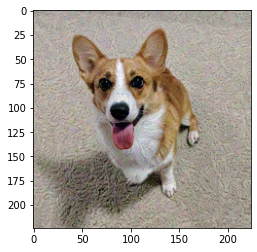

In [15]:
# 적대적 예제 시각화
# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

적대적 예제를 시각화해도 여전히 사람눈에는 큰 차이가 없어보입니다!

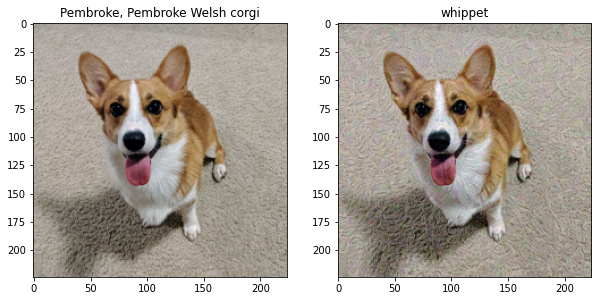

In [16]:
# 원본과 적대적 예제 나란히 시각화
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()


왼쪽이 원본, 오른쪽에 잡음을 더해 만든 적대적 예제입니다. 원본 주변에 노이즈가 생겼음을 알 수 있습니다. 딥러닝의 성능이 대단하지만 여전히 약점이 존재하고, 적대적 예제를 생성하고 방어하는 여러 연구가 활발히 진행중이라고 합니다.

오늘은 딥러닝 모델을 혼동시킬 수 있는 적대적 예제의 개념에 대해 알아보고 코드로 FGSM 공격을 구현해 보았습니다. 큰 공을 들여 학습한 모델도 큰 노력 없이 무력화될 수 있고, 이 점은 어느 머신러닝 모델도 개발자의 의도에 빗나가는 결과를 낼 수 있다는 것을 보여줍니다.